In [13]:
import os
import glob
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom

In [14]:
# read data
INPUT_DIR = 'rsna-2024-lumbar-spine-degenerative-classification'

train = pl.read_csv(f'{INPUT_DIR}/train.csv')
print(train.head())
train_label = pl.read_csv(f'{INPUT_DIR}/train_label_coordinates.csv')
print(train_label[1])
train_desc = pl.read_csv(f'{INPUT_DIR}/train_series_descriptions.csv')
print(train_desc)

shape: (5, 26)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ study_id ┆ spinal_ca ┆ spinal_ca ┆ spinal_ca ┆ … ┆ right_sub ┆ right_sub ┆ right_sub ┆ right_sub │
│ ---      ┆ nal_steno ┆ nal_steno ┆ nal_steno ┆   ┆ articular ┆ articular ┆ articular ┆ articular │
│ i64      ┆ sis_l1_l2 ┆ sis_l2_l3 ┆ sis_l3_l4 ┆   ┆ _stenosis ┆ _stenosis ┆ _stenosis ┆ _stenosis │
│          ┆ ---       ┆ ---       ┆ ---       ┆   ┆ _l2…      ┆ _l3…      ┆ _l4…      ┆ _l5…      │
│          ┆ str       ┆ str       ┆ str       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆           ┆           ┆           ┆   ┆ str       ┆ str       ┆ str       ┆ str       │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 4003253  ┆ Normal/Mi ┆ Normal/Mi ┆ Normal/Mi ┆ … ┆ Normal/Mi ┆ Normal/Mi ┆ Normal/Mi ┆ Normal/Mi │
│          ┆ ld        ┆ ld        ┆ ld        ┆   ┆ ld        ┆ ld        ┆

shape: (1, 3)
┌────────────┬────────────┬──────────┐
│ column_0   ┆ column_1   ┆ column_2 │
│ ---        ┆ ---        ┆ ---      │
│ i64        ┆ i64        ┆ i64      │
╞════════════╪════════════╪══════════╡
│ 4290709089 ┆ 3274612423 ┆ 9        │
└────────────┴────────────┴──────────┘
shape: (1, 3)
┌────────────┬────────────┬──────────┐
│ column_0   ┆ column_1   ┆ column_2 │
│ ---        ┆ ---        ┆ ---      │
│ i64        ┆ i64        ┆ i64      │
╞════════════╪════════════╪══════════╡
│ 4290709089 ┆ 3274612423 ┆ 9        │
└────────────┴────────────┴──────────┘
shape: (1, 3)
┌────────────┬────────────┬──────────┐
│ column_0   ┆ column_1   ┆ column_2 │
│ ---        ┆ ---        ┆ ---      │
│ i64        ┆ i64        ┆ i64      │
╞════════════╪════════════╪══════════╡
│ 4290709089 ┆ 3274612423 ┆ 9        │
└────────────┴────────────┴──────────┘
shape: (1, 3)
┌────────────┬────────────┬──────────┐
│ column_0   ┆ column_1   ┆ column_2 │
│ ---        ┆ ---        ┆ ---      │
│ i64   

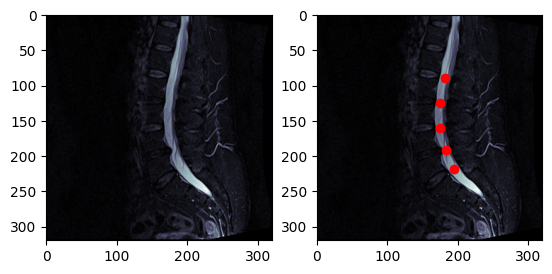

In [15]:
def graph_plot(study_id, series_id):
    train_label_combinations = pl.DataFrame()
    for row in train_label.iter_rows():
        if row[0]==study_id:
            print(pl.DataFrame(row[:3]).transpose())
            data = pl.DataFrame(row[:3]).transpose()
            train_label_combinations=pl.concat([train_label_combinations, data])
    print(train_label_combinations)
    
    #rename columns
    train_label_combinations = train_label_combinations.rename({"column_0":"study_id", "column_1":"series_id", "column_2":"instance_number"})
    #extract unique combination
    train_label_combinations = train_label_combinations.unique(subset=["study_id", "series_id", "instance_number"]).sort(["study_id", "series_id", "instance_number"])
    
    instance_number_list = train_label_combinations.filter((pl.col("study_id")==study_id) & (pl.col("series_id")==series_id)).get_column("instance_number")
    #instance_number_list

    for instance_number in instance_number_list:
        #print(instance_number)
        print(f"=====study_id:{study_id}, series_id:{series_id}, instance_number:{instance_number}=====")
        #read image
        ds = pydicom.read_file(f'{INPUT_DIR}/train_images/{study_id}/{series_id}/{instance_number}.dcm')
        #draw original image
        df_plt = train_label.filter(
            (pl.col('study_id')==study_id)
            &(pl.col('series_id')==series_id)
            &(pl.col('instance_number')==instance_number)
        )
        plt.subplot(1,2,1)
        plt.imshow(ds.pixel_array, cmap='bone')
        #plt.title(f"study_id:{study_id}, series_id:{series_id}, instance_number:{instance_number}")

        #draw original image + label
        #draw image
        df_plt = train_label.filter(
            (pl.col('study_id')==study_id)
            &(pl.col('series_id')==series_id)
            &(pl.col('instance_number')==instance_number)
        )
        plt.subplot(1,2,2)
        plt.imshow(ds.pixel_array, cmap='bone')
        #plt.title(f"study_id:{study_id}, series_id:{series_id}, instance_number:{instance_number}")
        #draw rabel
        for row in df_plt.iter_rows():
            plt.scatter(row[-2], row[-1], color='red')
        plt.show()

study_id, series_id = 4290709089, 3274612423
graph_plot(study_id, series_id)

# Visualize the pixel array

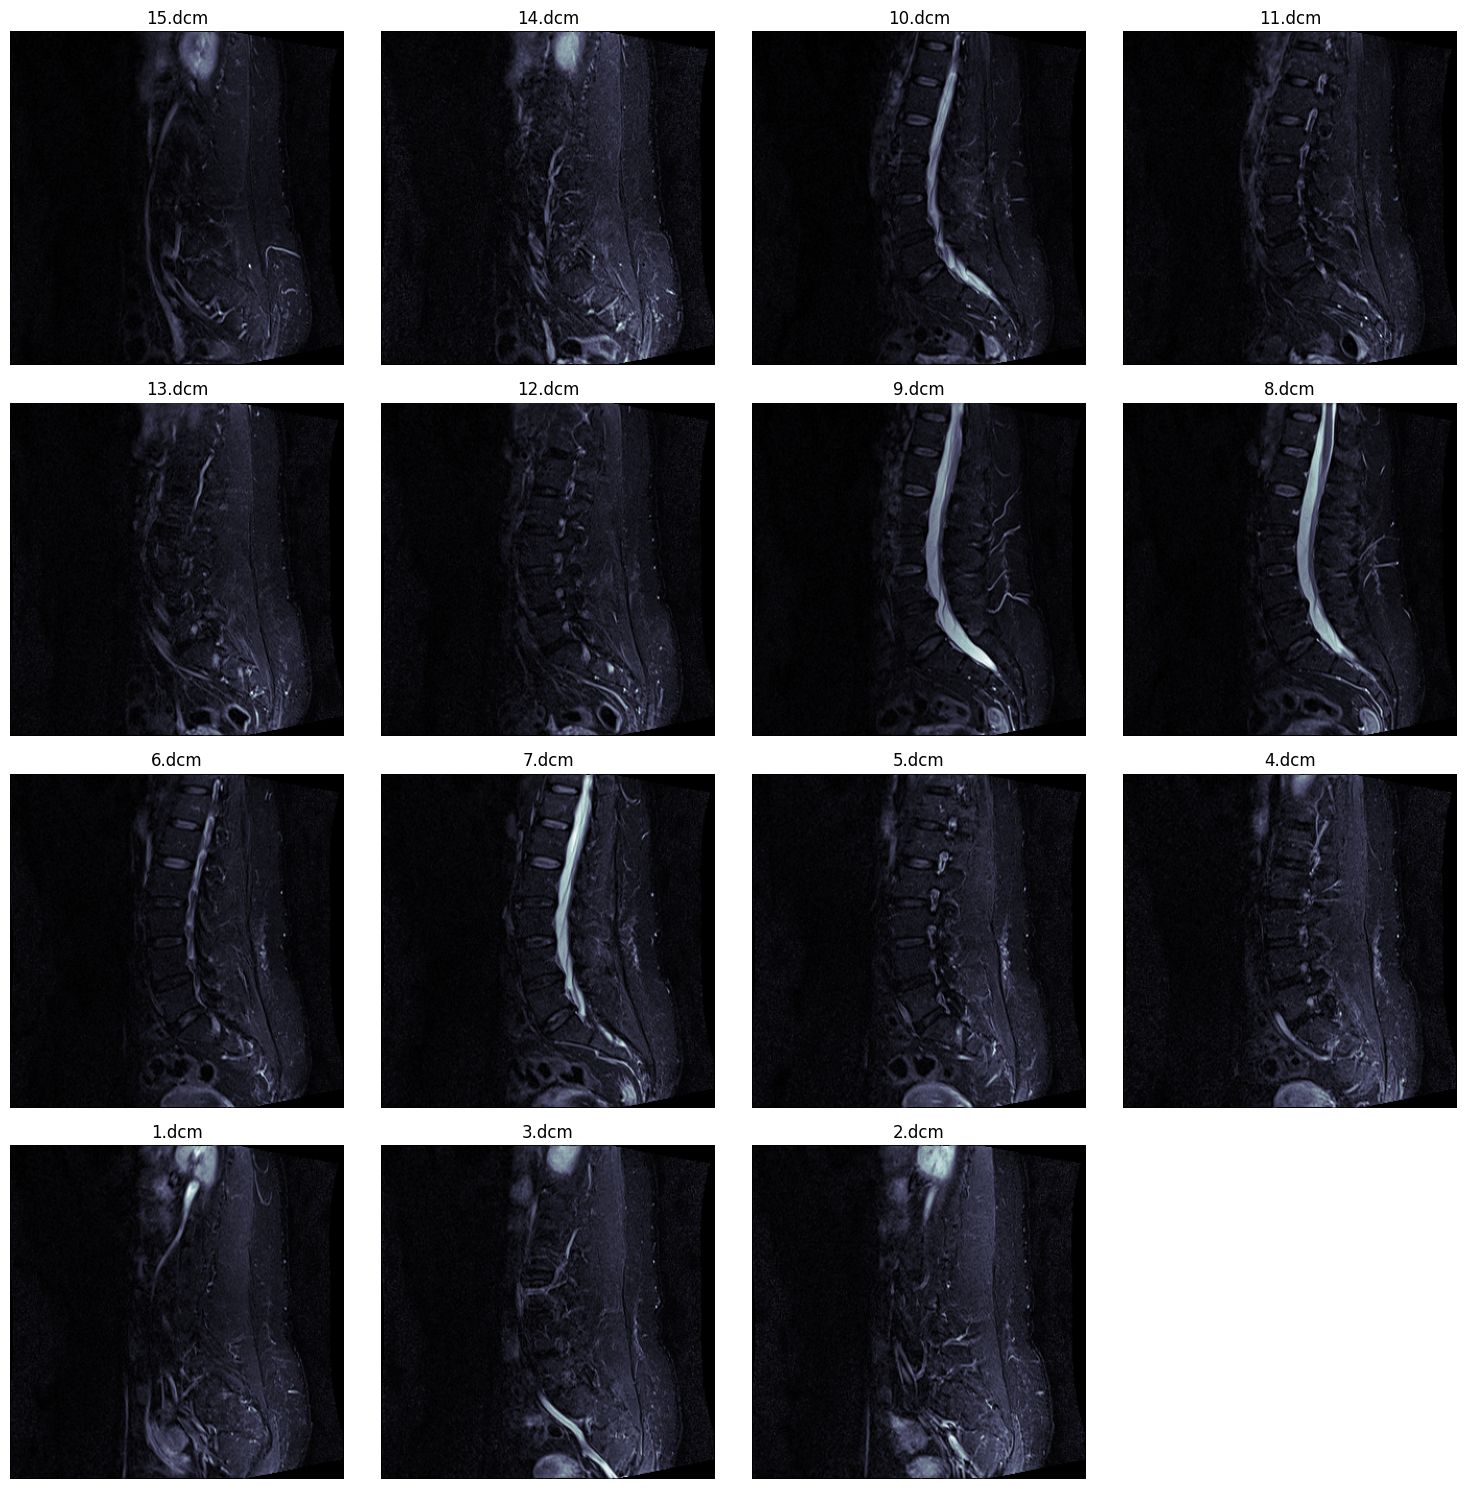

In [16]:
from PIL import Image

def visualizeImage(directory):
    images = [f for f in os.listdir(directory) if f.endswith('.dcm')]

    # Number of images
    grid_size = len(images)

    grid_size = int(grid_size ** 0.5) + 1

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15,15))

    axes = axes.flatten()

    for idx, file in enumerate(images):
        ds = pydicom.read_file(os.path.join(directory, file))
        axes[idx].imshow(ds.pixel_array, cmap='bone')
        axes[idx].set_title(file)
        axes[idx].axis('off')

    # Hide any remaining empty subplots
    for i in range(idx + 1, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show

directory =f'{INPUT_DIR}/train_images/{study_id}/{series_id}'
visualizeImage(directory)


In [17]:
def list_of_picture(directory):
    all_the_pic = []
    # path_dir = os.path.join(direc)

    for i in os.listdir(directory):
        all_the_pic.append(i)
    return all_the_pic

path_dir = f'{INPUT_DIR}/train_images/{study_id}/{series_id}'
list_of_picture(path_dir)

['15.dcm',
 '14.dcm',
 '10.dcm',
 '11.dcm',
 '13.dcm',
 '12.dcm',
 '9.dcm',
 '8.dcm',
 '6.dcm',
 '7.dcm',
 '5.dcm',
 '4.dcm',
 '1.dcm',
 '3.dcm',
 '2.dcm']

# Check for missing data

In [20]:
data = pd.read_csv("rsna-2024-lumbar-spine-degenerative-classification/train.csv")
missing_values_count = pd.isnull(data).sum()
print(missing_values_count)

study_id                                    0
spinal_canal_stenosis_l1_l2                 1
spinal_canal_stenosis_l2_l3                 1
spinal_canal_stenosis_l3_l4                 1
spinal_canal_stenosis_l4_l5                 1
spinal_canal_stenosis_l5_s1                 1
left_neural_foraminal_narrowing_l1_l2       2
left_neural_foraminal_narrowing_l2_l3       2
left_neural_foraminal_narrowing_l3_l4       2
left_neural_foraminal_narrowing_l4_l5       2
left_neural_foraminal_narrowing_l5_s1       2
right_neural_foraminal_narrowing_l1_l2      8
right_neural_foraminal_narrowing_l2_l3      8
right_neural_foraminal_narrowing_l3_l4      8
right_neural_foraminal_narrowing_l4_l5      8
right_neural_foraminal_narrowing_l5_s1      8
left_subarticular_stenosis_l1_l2          164
left_subarticular_stenosis_l2_l3           82
left_subarticular_stenosis_l3_l4            3
left_subarticular_stenosis_l4_l5            3
left_subarticular_stenosis_l5_s1           11
right_subarticular_stenosis_l1_l2 